In [1]:
from sklearn.model_selection import train_test_split as tts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import player_model 
import draft_model 
import final_model
import util
import model_analysis

%matplotlib inline
np.random.seed(0)

Load match data sourced from oracles elixir, and merge with player model information

In [2]:
match_data = util.load_match_data()
util.print_match_and_player_data(match_data)

,teamname,opponent,date,league,result,top_dif,jng_dif,mid_dif,bot_dif,sup_dif
0,ROX Tigers,KT Rolster,2017-01-17 07:10:23,LCK,0,-2.344660,-2.409820,-0.712900,-2.300489,-1.702800
1,KT Rolster,ROX Tigers,2017-01-17 07:10:23,LCK,1,2.344660,2.409820,0.712900,2.300489,1.702800
2,Longzhu Gaming,Samsung Galaxy,2017-01-17 10:04:07,LCK,1,0.248975,0.482163,0.973789,0.527127,1.420935
3,Samsung Galaxy,Longzhu Gaming,2017-01-17 10:04:07,LCK,0,-0.248975,-0.482163,-0.973789,-0.527127,-1.420935
4,bbq Olivers,MVP,2017-01-18 10:06:32,LCK,0,0.256832,-0.049755,0.121897,-1.606031,-0.198971


Fit the player model using the player differences. The logistic regression that uses draft information also interacts whether champions are most impactful in the early, mid, or late game.

In [3]:

player_model.calculate_positional_differences(match_data)
player_model.fit_player_model(match_data, use_draft_info=False)
player_model.fit_player_model(match_data, use_draft_info=True)
util.print_player_lead_probabilities(match_data)

,teamname,opponent,post_draft_top_lead_prob,post_draft_mid_lead_prob,post_draft_bot_lead_prob,draft_agnostic_top_lead_prob,draft_agnostic_mid_lead_prob,draft_agnostic_bot_lead_prob
0,ROX Tigers,KT Rolster,0.350542,0.353701,0.302976,0.326408,0.395956,0.323555
1,KT Rolster,ROX Tigers,0.660396,0.647507,0.698018,0.670732,0.604044,0.678149
2,Longzhu Gaming,Samsung Galaxy,0.511512,0.563308,0.612205,0.520898,0.571404,0.562983
3,Samsung Galaxy,Longzhu Gaming,0.481604,0.439663,0.404171,0.475864,0.428596,0.438935
4,bbq Olivers,MVP,0.511983,0.507584,0.382508,0.513222,0.506165,0.415071


Map each champion to its reduced role form. For each team sum over all comprising champions.

In [4]:
champion_mapping = draft_model.load_champion_mapping()
match_drafts = draft_model.reduce_team_drafts(match_data, champion_mapping)
util.print_team_reduced_drafts(match_drafts)

,id,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,ap,ad,no_damage_type
0,0,0,1,2,0,1,0,1,0,0,3,2,2,2,0
1,1,0,0,1,0,2,1,1,0,1,3,1,2,2,0
2,2,1,1,1,0,1,1,0,0,2,2,1,2,3,0
3,3,0,1,2,0,1,1,0,0,2,1,2,2,2,0
4,4,0,0,1,0,1,1,2,0,1,3,1,2,2,0


Cluster all teams' drafts into 7 clusters.

In [5]:
N_clusters = 7
match_drafts = draft_model.cluster_drafts(match_drafts, n_clusters=N_clusters)
util.print_draft_centroids(match_drafts)

,team_Dives,team_Tanks,team_Damages,team_Enchanters,team_Picks,team_Pokes,team_Engages,team_Splitpushs,early_game,mid_game,late_game,no_damage_type
team_comp,,,,,,,,,,,,
0,0.332481,1.859518,1.249726,0.036536,0.297589,0.794118,0.422178,0.007855,0.925100,1.679028,2.395871,0.0
1,0.343992,0.488372,1.989503,0.026001,0.296673,0.261789,1.590278,0.003391,1.242087,1.800226,1.957687,0.0
2,0.517432,0.691560,1.255477,1.067822,0.290913,0.594018,0.543723,0.039055,1.514384,1.268242,2.217375,0.0
3,0.533745,0.572964,0.619749,0.161855,1.022297,1.156878,0.854669,0.077842,2.372686,1.680470,0.946845,0.0
4,1.235379,0.765526,1.044541,0.094333,0.350172,0.474742,0.981894,0.053413,1.077494,3.089625,0.832881,0.0
5,0.548780,1.295122,1.079268,0.413415,0.201220,0.451220,0.806098,0.204878,1.113415,1.926829,1.959756,1.0
6,0.240100,0.748791,1.081706,0.213223,0.383444,0.554202,0.741444,1.037090,1.001075,1.802544,2.196381,0.0


Merge information from draft clusters and player model win probabilities, and the list of composition that played against each in the dataset.

In [6]:
full_data, list_of_comp_diffs = util.merge_team_and_draft(match_data, match_drafts, N_clusters)

Train draft agnostic control model and final post draft model

In [7]:
train, test = tts(full_data, test_size=0.3, random_state=0)
draft_agnostic_model = final_model.train_draft_agnostic_model(train)
post_draft_model = final_model.train_post_draft_model(train, list_of_comp_diffs, full_data)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6179458645442353
            Iterations: 99
            Function evaluations: 100
            Gradient evaluations: 99


In [8]:
final_model.predict_with_model(full_data, draft_agnostic_model, "draft_agnostic")
final_model.predict_with_model(full_data, post_draft_model, "post_draft")

# How much did a team improve their win probability through draft
full_data["draft_diff"] = full_data["post_draft_win_prob"] - full_data["draft_agnostic_win_prob"]

util.print_win_prob_model_outputs(full_data)

,teamname,opponent,result,draft_agnostic_win_prob,post_draft_win_prob,draft_diff
0,ROX Tigers,KT Rolster,0,0.408006,0.277817,-0.130188
1,KT Rolster,ROX Tigers,1,0.591994,0.722183,0.130188
2,Longzhu Gaming,Samsung Galaxy,1,0.605627,0.636196,0.030569
3,Samsung Galaxy,Longzhu Gaming,0,0.394373,0.363804,-0.030569
4,bbq Olivers,MVP,0,0.325416,0.391554,0.066138


Output model statistics and compare with collected odds from Bet365 after the have been adjusted for hold

In [9]:
# Using the same random state gives the same test train split
# We need to do this as the original model does not have the normalised win probs for each side of the match
train, test = tts(full_data, test_size=0.3, random_state=0)
model_analysis.print_model_results(test)
print("------------------------")
model_analysis.print_bookie_stats()

Draft Agnostic models:
    
    Lane lead average Brier score: 	0.2380959739351781
    Lane lead average accuracy: 	0.5900345337937839
    Win prob Brier score: 		0.2319430290167538
    Win prob accuracy: 			0.6148001973359645
    
Post Draft models:
    
    Lane lead average Brier score: 	0.23674404338965693
    Lane lead average accuracy: 	0.5955270514717974
    Win prob Brier score: 		0.21534915568329263
    Win prob accuracy: 			0.6548593981253084
    
------------------------
After adjusting for hold:

    Bookie Brier score:
    0.22284981228499326

    Bookie accuracy
    0.6435495898583147
    


Ouput the calibration plot of the post draft model

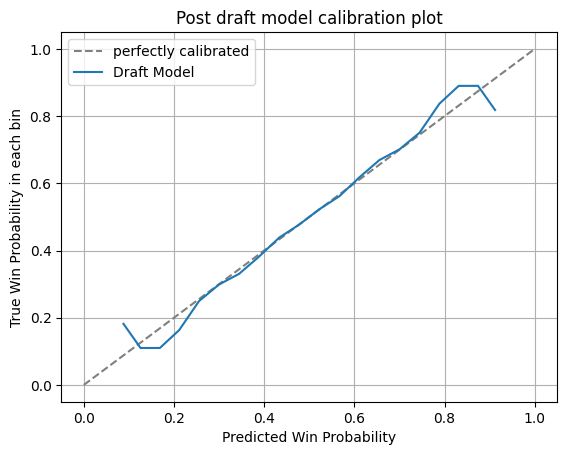

In [10]:
model_analysis.calibration_plot(full_data)

Output which teams in the LoL European Championship added the most expected wins as a result of draft through the 2022 Spring and Summer split. LEC version not shown in the final paper.

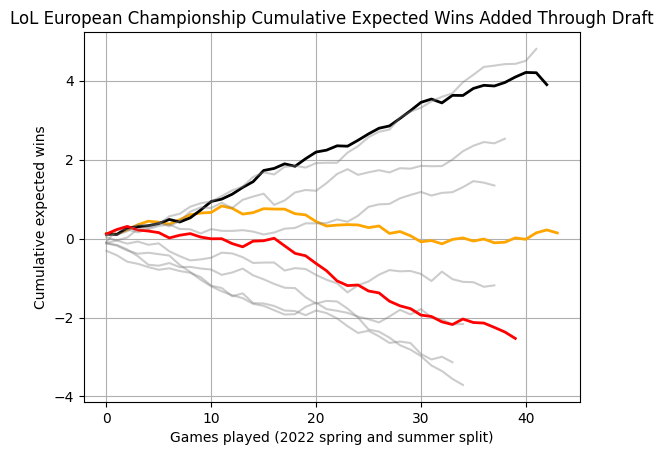

In [11]:
teams = {'G2 Esports':'black', 'Fnatic':'orange', 'Misfits Gaming':'red'}
ax = model_analysis.plot_cumulative_expected_wins_added_by_draft(full_data, league='LEC', teams=teams)
ax.set_title("LoL European Championship Cumulative Expected Wins Added Through Draft");

Count the times teams played each teamcomp in the last 2 years of the LCS

In [12]:
recent_LCS_games = full_data.query("league == 'LCS' & date > '2021-01-01'").copy()
LCS_teamcomps = model_analysis.get_teamcomps_for_lcs(recent_LCS_games)
LCS_teamcomps.head(10)

teamcomp,0,1,2,3,4,5,6
teamname,,,,,,,
100 Thieves,16.0,19.0,18.0,20.0,25.0,0.0,8.0
Cloud9,14.0,23.0,20.0,16.0,16.0,2.0,19.0
Counter Logic Gaming,8.0,21.0,16.0,11.0,18.0,1.0,17.0
Dignitas,13.0,20.0,11.0,17.0,17.0,1.0,14.0
Evil Geniuses,16.0,26.0,14.0,14.0,27.0,0.0,10.0
FlyQuest,21.0,20.0,17.0,11.0,14.0,0.0,13.0
Golden Guardians,13.0,25.0,14.0,6.0,19.0,1.0,16.0
Immortals,8.0,26.0,14.0,8.0,18.0,1.0,17.0
TSM,8.0,34.0,21.0,14.0,14.0,0.0,7.0


Team Liquid drafts cluster 6 disproportionately often when compared to the rest of the teams in the LCS

In [13]:
std = (LCS_teamcomps[6]["Team Liquid"] - LCS_teamcomps[6].mean()) / LCS_teamcomps[6].std()
print(f"Team Liquid drafts cluster 6 at {round(std, 2)} standard deviations above the league wide mean")

Team Liquid drafts cluster 6 at 2.26 standard deviations above the league wide mean


Plot the frequency breakdown of each teamcomp cluster for all teams in LCS and Team Liquid

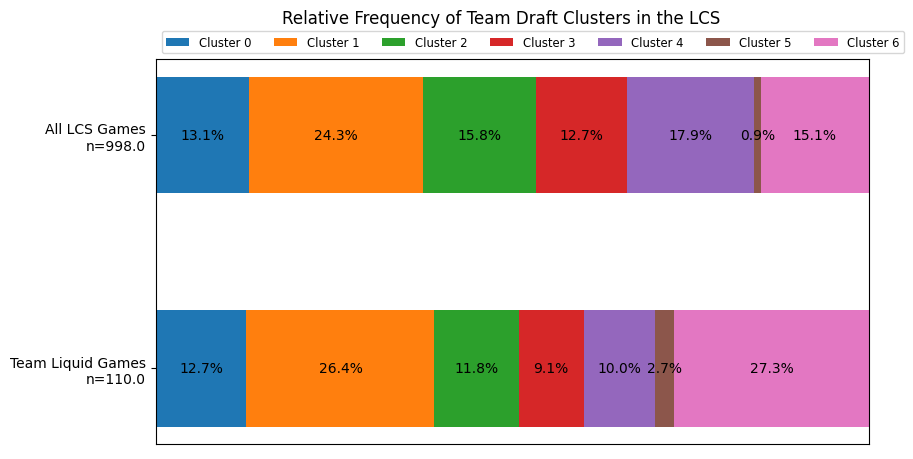

In [14]:
model_analysis.show_team_comp_frequencies(LCS_teamcomps);

Plot the expected wins added through draft for the LCS. Unlike the LEC version, this figure is included in the final paper.

Text(0.5, 1.0, 'LoL Championship Series Cumulative Expected Wins Added Through Draft')

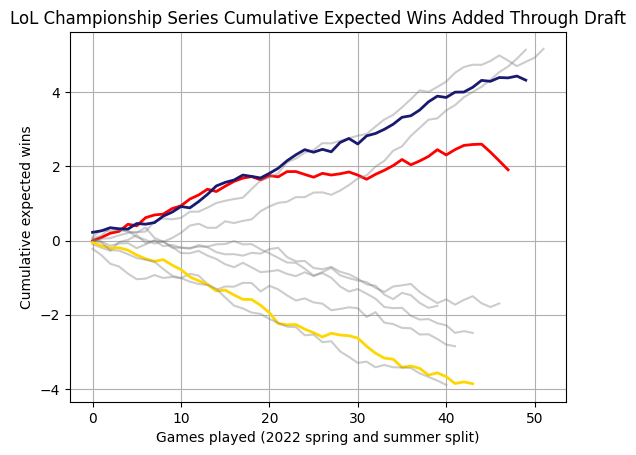

In [15]:
teams = {'Team Liquid':'midnightblue', '100 Thieves':'red', 'Golden Guardians':'gold'}
ax = model_analysis.plot_cumulative_expected_wins_added_by_draft(full_data, league='LCS', teams=teams)
ax.set_title("LoL Championship Series Cumulative Expected Wins Added Through Draft")

Plot the correlation between post-draft and draft-agnostic lane leads over 2 years of LCS games. Mid lane has a higher R^2 value than the other two lanes suggesting they are less affected by draft.


Bot lane R^2: 0.85
Mid lane R^2: 0.93 
Top lane R^2: 0.82



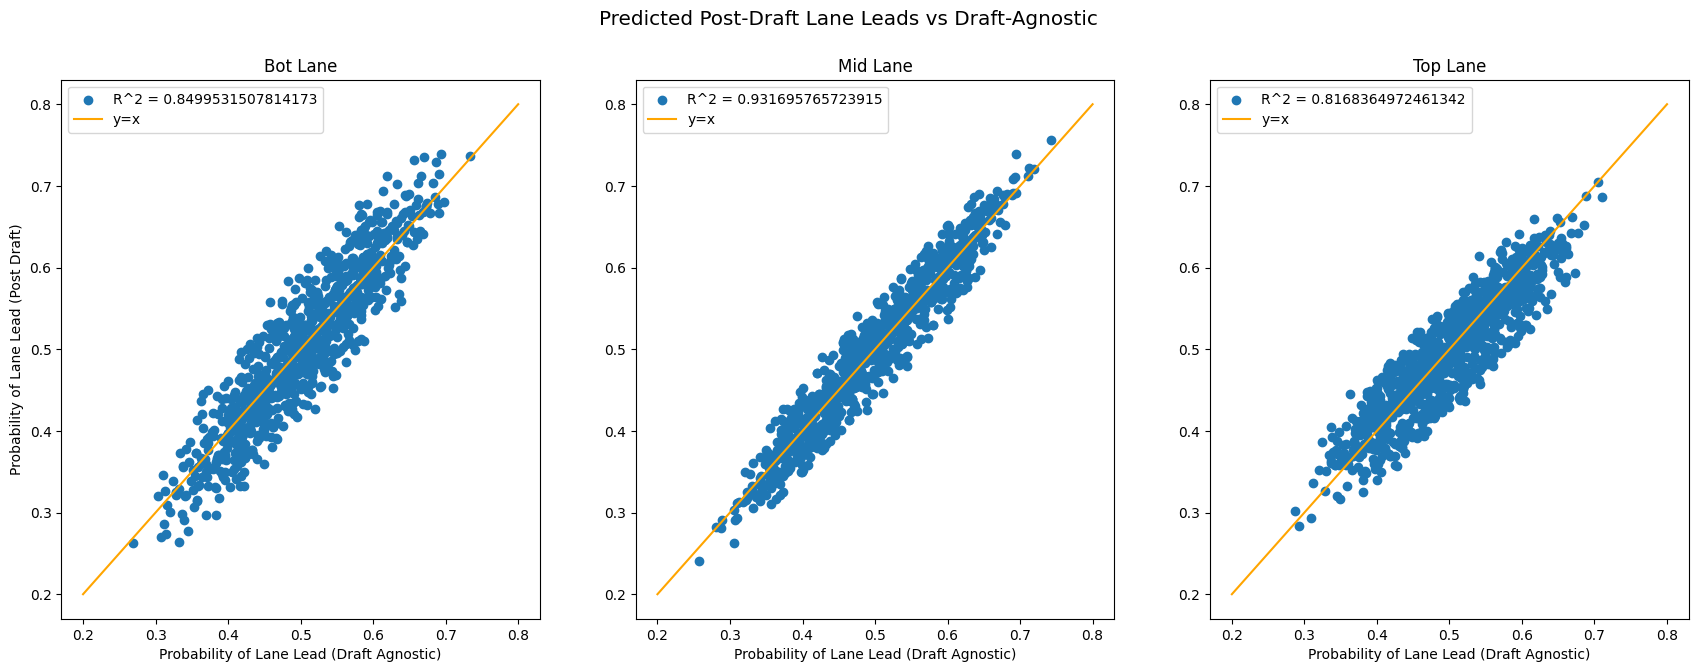

In [16]:
r2_bot, r2_mid, r2_top = model_analysis.lane_lead_correlations(recent_LCS_games);

print(f"""
Bot lane R^2: {round(r2_bot, 2)}
Mid lane R^2: {round(r2_mid, 2)} 
Top lane R^2: {round(r2_top, 2)}
""")

Plot Jojopyun's mid lane leads above expected for the most recent year of the LCS.

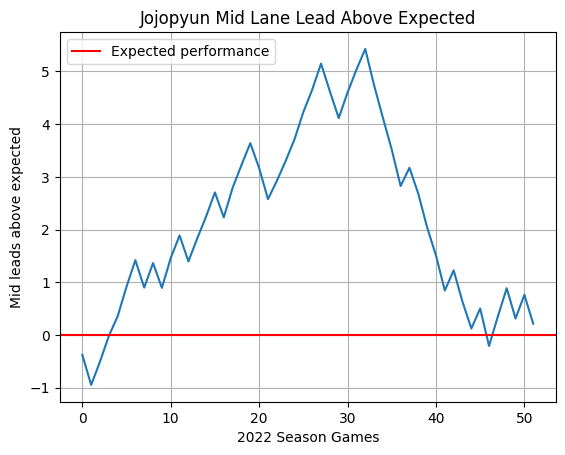

In [17]:
recent_EG_games = full_data.query("teamname == 'Evil Geniuses' and date > '2022-01-01'").copy()
model_analysis.plot_jojopyun_lane_lead_above_expected(recent_EG_games)